In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    project_root = os.path.dirname(current_dir)
elif current_dir.endswith("signal_synthesiser"):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir)

# Load the Labeled Data
data_path = os.path.join(project_root, "data", "processed", "labelled_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    print(f"Data Loaded. Shape: {df.shape}")
else:
    print("Data not found.")

# Load all Models
model_dir = os.path.join(project_root, "models")
models = {}

model_names = {
    'rf_v1': 'rf_v1.joblib',        
    'rf_opt': 'rf_opt.joblib',      
    'xgb_v1': 'xgb_v1.joblib',      
    'xgb_opt': 'xgb_opt.joblib'     
}

print("\n--- Loading Models ---")
for key, filename in model_names.items():
    path = os.path.join(model_dir, filename)
    if os.path.exists(path):
        models[key] = joblib.load(path)
        print(f"Loaded {key}")
    else:
        print(f"Warning: {filename} not found. Comparison will be incomplete.")


Data Loaded. Shape: (2161, 24)

--- Loading Models ---
Loaded rf_v1
Loaded rf_opt
Loaded xgb_v1
Loaded xgb_opt


In [11]:
# Prepare the Test Data
test_start = "2022-01-01"
test_data = df[df.index >= test_start].copy()

# Calculate Market Returns 
test_data['Market_Returns'] = test_data['Close'].pct_change()
test_data.dropna(inplace=True)

features = [
    'Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', 
    'Volatility', 'VIX_Norm', 'Is_Friday', 'Volume'
]

X_test = test_data[features]
y_test = test_data['Target_Label']

print(f"Testing on {len(test_data)} days of unseen data (2022-2024).")

def run_backtest(model, X, market_returns):
    preds = model.predict(X)
    strategy_returns = preds[:-1] * market_returns.values[1:]
    strategy_returns = np.append(strategy_returns, 0)
    return strategy_returns

# Iterate through loaded models and run backtest
for name, model in models.items():
    col_name = f'Strategy_{name}'
    test_data[col_name] = run_backtest(model, X_test, test_data['Market_Returns'])
    print(f"Computed returns for: {name}")

Testing on 495 days of unseen data (2022-2024).
Computed returns for: rf_v1
Computed returns for: rf_opt
Computed returns for: xgb_v1
Computed returns for: xgb_opt


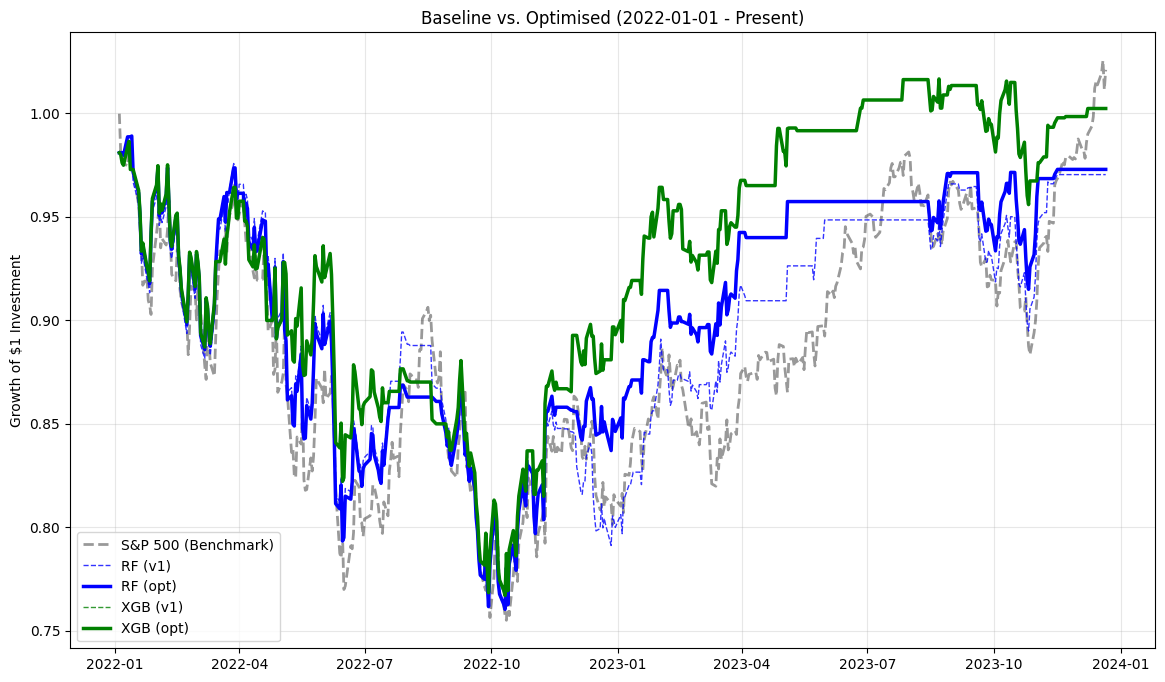

In [12]:
# Calculate Cumulative Returns for everything that exists
plt.figure(figsize=(14, 8))

# Plot Market 
test_data['Cum_Market'] = (1 + test_data['Market_Returns']).cumprod()
plt.plot(test_data.index, test_data['Cum_Market'], label='S&P 500 (Benchmark)', color='black', alpha=0.4, linestyle='--', linewidth=2)

# Plot Models 
colors = {'rf': 'blue', 'xgb': 'green'}
styles = {'v1': '--', 'opt': '-'} 

for name in models.keys():
    model_type, version = name.split('_')
    
    cum_ret = (1 + test_data[f'Strategy_{name}']).cumprod()
    
    label = f"{model_type.upper()} ({version})"
    plt.plot(test_data.index, cum_ret, label=label, color=colors[model_type], linestyle=styles[version], alpha=0.8 if version=='v1' else 1.0, linewidth=1 if version=='v1' else 2.5)

plt.title(f"Baseline vs. Optimised ({test_start} - Present)")
plt.ylabel("Growth of $1 Investment")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
def get_metrics(returns):
    total_return = (np.prod(1 + returns) - 1)
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    max_dd = (cum - peak).min()
    
    return total_return, sharpe, max_dd

metrics_list = []
m_ret, m_sharpe, m_dd = get_metrics(test_data['Market_Returns'])
metrics_list.append({'Model': 'Market (SPY)', 'Return': m_ret, 'Sharpe': m_sharpe, 'Drawdown': m_dd})

for name in models.keys():
    ret, sharpe, dd = get_metrics(test_data[f'Strategy_{name}'])
    metrics_list.append({'Model': name, 'Return': ret, 'Sharpe': sharpe, 'Drawdown': dd})

results = pd.DataFrame(metrics_list)
results.set_index('Model', inplace=True)
results['Return'] = results['Return'].apply(lambda x: f"{x:.2%}")
results['Drawdown'] = results['Drawdown'].apply(lambda x: f"{x:.2%}")
results['Sharpe'] = results['Sharpe'].apply(lambda x: f"{x:.2f}")

results

,Return,Sharpe,Drawdown
Model,,,
Market (SPY),2.08%,0.15,-24.46%
rf_v1,-2.97%,0.00,-21.81%
rf_opt,-2.72%,0.01,-22.86%
xgb_v1,0.22%,0.09,-21.93%
xgb_opt,0.22%,0.09,-21.93%
